# Datenmangel? Copy & augmentated Paste

## CNN Übung
In diesem Notebook werden Sie mehrschichtige Perzeptronen (MLP, engl. Multilayer Perceptrons) mit Convolutional Neural Networks (CNN) vergleichen, um eine einfache Aufgabe wie die Erkennung von 10 verschiedenen Objekten aus Bildern zu lösen. Sie werden alles mit Keras programmieren und die Ergebnisse mit den bereits gelernten Metriken für die Klassifizierung vergleichen.

### Importe

In [54]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Protobuf gencode version")
from ipywidgets import widgets
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np

# For some convolving operations
from scipy import signal
# from scipy import misc

# DeepLearning Library Keras
# Documentation https://keras.io/
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Reshape,Activation
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10

import utils

#define dataroot
root = 'data/dataset/'


### Definitionen

In [2]:
#### DO NOT EDIT!
# For specifiying training with autoencoder structure
ae_specification = widgets.Text()
old_spec = 'None'


# Two Loggers, depending if loss or accuracy should be visualized
Loss_Logger = utils.LossGraph('loss')
Acc_Logger = utils.LossGraph('accuracy')

# Size for some plots with matplotlib
figure_inches = 3

### Cifar-10 Klassifikationsaufgabe
Neben dem MNIST-Datensatz ist auch Cifar10 ein kleiner Datensatz, der in den Anfängen der CNNs verwendet wurde. Es gibt 10 verschiedene Klassen von einfachen Objekten oder Tieren. Die Bilder haben eine Größe von 32x32x3. In diesem Abschnitt sollten Sie ein gegebenes CNN tunen, um Bilder mit hoher Genauigkeit zu klassifizieren. 

Siehe auch: [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html)


<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.1:</b> Laden Sie den Datensatz, legen Sie die Anzahl der Klassen fest, transformieren Sie die Beschriftungen und definieren Sie alle zugehörigen Klassen (wie z.B. Flugzeug,...) gemäß den Kommentaren in den Codezellen.

</div>

In [3]:
# Load the dataset from Keras, Tip: cifar10 is already imported, train + test set required
# HINT: Load the dataset into this structure: "(x_train, y_train), (x_test, y_test) = ..."

# STUDENT CODE HERE
(x_train, y_train), (x_test, y_test) =keras.datasets.cifar10.load_data()
# STUDENT CODE until HERE

In [4]:
# How many classes are in Cifar-10? 
# Hint: Name the variable "num_classes = ..."

# STUDENT CODE HERE
num_classes=10
# STUDENT CODE until HERE
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], shape=(50000, 1), dtype=uint8)

In [5]:
# Transform the labels into categorical vectors
# Use the keras.utils.to_categorical function

# Hint: "y_train_categorical = ..."
# Hint2: "y_test_categorical = ..."

# STUDENT CODE HERE
y_train_categorical = keras.utils.to_categorical(y_train,num_classes=num_classes)
y_test_categorical = keras.utils.to_categorical(y_test,num_classes=num_classes)
print(y_train_categorical)
# STUDENT CODE until HERE

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [6]:
# What classes are there? Define them in a list of strings named classes.
# Hint: Call the list of strings "classes = ..."

# STUDENT CODE HERE
classes=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
# STUDENT CODE until HERE

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.2:</b> Prüfen Sie, ob Sie alles wie gewünscht definiert haben.

</div>

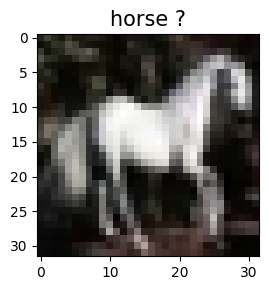

In [7]:
# Image in the training set
number_sample = 13  # test multiple ones

fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title(classes[y_test[number_sample].item()]+' ?', fontsize = 15)
ax.imshow(x_test[number_sample,:,:,:], interpolation='nearest')
plt.tight_layout()

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.3:</b> Suchen Sie ein Bild eines Pferdes und plotten Sie es mit dem Code oben. Sie können die gleiche Code-Zelle verwenden.

</div>

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.4:</b> Preprocessen Sie die Daten, um Werte zwischen 0 und 1 zu gewährleisten. Dividieren Sie dazu die rgb-Werte durch ihren Maximalwert.

</div>

In [8]:
# Data Preprocessing
# Divide RGB values of train AND test set 
# by their maximum value to ensure values between [0,1]

# STUDENT CODE HERE
print(np.min(x_test))
print(np.max(x_test))
x_test=x_test/np.max(x_test)
x_train=x_train/np.max(x_train)
print(np.max(x_test))
# STUDENT CODE until HERE

0
255
1.0


<div class="alert alert-block alert-success">
<b>Frage 5.3.5:</b> Wie viele Trainings- und Testdaten gibt es?
</div>


In [9]:
print("Bildgröße:")
print(x_test[0,0].shape)
print(len(x_test[0,:]))
print("Anzahl an Testsamples:")
print(len(x_test[:,0]))
print("Anzahl an Trainingssamples:")
print(len(x_train[:,0]))

Bildgröße:
(32, 3)
32
Anzahl an Testsamples:
10000
Anzahl an Trainingssamples:
50000


<div class="alert alert-block alert-success">
<b>Frage 5.3.6:</b> Warum Daten normalisieren?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b> Relative Werte sind besser als absolute Werte. Bilder weißen Werte von 0 bis 255 auf, was numerisch mehrere Zeitskalen bedeutet. Unter- oder Überläufe werden verhindert. Die Aktivierungsfunktionen sind für normalisierte Daten ausgelegt.</div>


<div class="alert alert-block alert-success">
<b>Frage 5.3.7:</b> Warum wird ein kategorischer Vektor an Stelle eines einzelnen Outputs verwendet?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b> Weil man dann mit den einzelnen Outputs (0-9) nicht rechnen kann, z.B. für die Bildung von Beträgen</div>


## Klassifikationsmodelle für Cifar-10

### Neuronales Netzwerk Klassifikator:

In [10]:
def model_nn()->Model:
    
    input_layer = Input(shape = x_train.shape[1:], name='Input_MLP')
    
    flatten = Flatten(name='Flattening_MLP')(input_layer)
    
    hidden1 = Dense(256, activation = 'relu', name='Hidden1_NN')(flatten)
    hidden2 = Dense(256, activation = 'relu', name='Hidden2_NN')(hidden1)
    
    output = Dense(num_classes, activation = 'softmax', name='Output_NN')(hidden2)
    
    model = Model(inputs= input_layer, outputs = output)
    
    
    return model

### Convolutional Neural Network Klassifikator:

In [11]:
def model_cnn()->Model:
    
    input_layer = Input(shape = x_train.shape[1:], name='Input_CNN') # channels last
    
    conv1 = Conv2D(filters= 16, kernel_size = (3,3), padding='same', name='Conv1')(input_layer)
    batch1=BatchNormalization()(conv1)
    act1=Activation("relu")(batch1)
    max_pool1 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding='valid', name='Pool1')(act1)
    
    # filters= Dimension des Outputs
    conv2 = Conv2D(filters = 32, kernel_size = (3,3), padding='same', name='Conv2')(max_pool1)
    batch2=BatchNormalization()(conv2)
    act2=Activation("relu")(batch2)
    max_pool2 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding='valid', name='Pool2')(act2)

    # conv3 = Conv2D(filters = 64, kernel_size = (3,3), padding='same', name='Conv3')(max_pool2)
    # batch3=BatchNormalization()(conv3)
    # act3=Activation("relu")(batch3)
    # max_pool3 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding='valid', name='Pool3')(act3)

    flattened = Flatten(name='Flatt_CNN')(max_pool2)
    
    fc1 = Dense(256, activation = 'relu', name='FC-1')(flattened)
    drop3=Dropout(0.5)(fc1)
    output = Dense(num_classes,kernel_regularizer='l2', activation = 'softmax', name='Output_CNN')(drop3)#,kernel_regularizer='l1'
    
    model = Model(inputs= input_layer, outputs = output)
        
    return model

### Vergleich von MLP und CNN Klassifikatoren:

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.8:</b> Um die Bilder in Cifar-10 zu klassifizieren, verwenden Sie die gegebenen MLP- und CNN-Modelle, um zu untersuchen, welches besser abschneidet.
Trainieren Sie beide Netzwerke für 10 Epochen und schauen Sie sich die Ergebnisse an.
Fühlen Sie sich frei, den Code in den beiden Code-Zellen unten zu verwenden und zu ändern. Wenn Ihr Netzwerk nicht trainiert, haben Sie möglicherweise die rgb-Werte nicht richtig aufbereitet (z. B. haben Sie nicht normalisiert oder zu oft).
</div>

<div class="alert alert-block alert-info">
<b>Hinweis:</b> Aufbau der folgenden Codezellen
<ul>
<li> Benutzen Sie die vordefinierten Funktionen, um Ihr Modell zu erstellen
<li> Definieren Sie den gemeinsamen TensorBoard-Logger mit der Konfiguration, um die Trainingsergebnisse später zu betrachten (Terminal: tensorboard --logdir=path/to/log-directory und localhost:6006)
<li> Kompillieren und trainieren Sie das Modell
<li> Tipp: Wenn Ihre Modelle nichts Lernen, überprüfen Sie Ihre Datennormalisierung. Vielleicht haben Sie Ihre Daten nicht oder zu oft normalisiert.
</li>


</ul>


</div>

In [12]:
 # Train the Neural Network (MLP)

nn_model = model_nn()
config_nn = 'myconfig' # Give a recognizable name

# The TensorBoard is a feature of tensorflow for the visualization of the training process 
# nn_logger = TensorBoard(log_dir='logs/nn_logs/'+config_nn+'/')

nn_model.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer='Adam')
history=nn_model.fit(x_train, y_train_categorical, batch_size = 32, epochs = 10, 
            validation_data = (x_test, y_test_categorical), verbose = 1)



Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3284 - loss: 1.8510 - val_accuracy: 0.3861 - val_loss: 1.6890
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4012 - loss: 1.6677 - val_accuracy: 0.4344 - val_loss: 1.5824
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4275 - loss: 1.5952 - val_accuracy: 0.4204 - val_loss: 1.6094
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4456 - loss: 1.5453 - val_accuracy: 0.4412 - val_loss: 1.5552
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4599 - loss: 1.5127 - val_accuracy: 0.4390 - val_loss: 1.5756
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4648 - loss: 1.4855 - val_accuracy: 0.4649 - val_loss: 1.5055
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4735 - loss: 1.4634 - val_accuracy: 0.4601 - val_loss: 1.5299
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4821 - loss: 1.4405 - 

Accuracy:
0.462799996137619


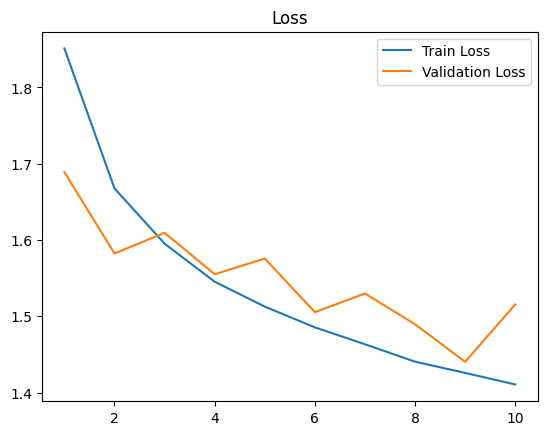

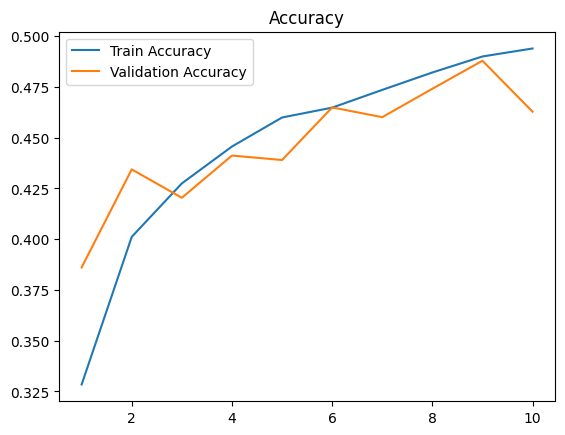

In [13]:
plt.figure()
plt.plot(np.arange(1,11,1),history.history['loss'],label="Train Loss")
plt.plot(np.arange(1,11,1),history.history['val_loss'],label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.figure()
plt.plot(np.arange(1,11,1),history.history['accuracy'],label="Train Accuracy")
plt.plot(np.arange(1,11,1),history.history['val_accuracy'],label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

score = nn_model.evaluate(x_test, y_test_categorical, verbose=0)
print("Accuracy:")
print(score[1])

In [14]:
# Train the Neural Network (CNN)
cnn_model = model_cnn()
config_cnn = 'myconfig' # Give a recognizable name

# The TensorBoard is a feature of tensorflow for the visualization of the training process 
# cnn_logger = TensorBoard(log_dir='logs/cnn_logs/'+config_cnn+'/') 
n_batch=20
cnn_model.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer='Adam')
history=cnn_model.fit(x_train, y_train_categorical, batch_size = 64, epochs = n_batch, 
            validation_data = (x_test, y_test_categorical))

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.4057 - loss: 1.6848 - val_accuracy: 0.4935 - val_loss: 1.4600
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5166 - loss: 1.3554 - val_accuracy: 0.4955 - val_loss: 1.3784
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5615 - loss: 1.2371 - val_accuracy: 0.6239 - val_loss: 1.0930
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5886 - loss: 1.1751 - val_accuracy: 0.6020 - val_loss: 1.1197
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6062 - loss: 1.1252 - val_accuracy: 0.5995 - val_loss: 1.1803
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6227 - loss: 1.0870 - val_accuracy: 0.5961 - val_loss: 1.1523
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6364 - loss: 1.0501 - val_accuracy: 0.6408 - val_loss: 1.0235
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6465 - loss: 1.0247 - val_accu

Accuracy:
0.6704000234603882
1.Wert: 0.6937999725341797
mit l1 in 2. dense-layer: 0.6696000099182129
mit l2 in 2. dense-layer: 0.7009000182151794
mit Dropout nach input: 0.6467999815940857
mit l2 in 1. dense-layer: 0.6060000061988831
mit Dropout nach 1. dense layer, 0.1: 0.7028999924659729
mit Dropout nach 1. dense layer, 0.2: 0.6952999830245972
mit Dropout nach 1. dense layer, 0.2: 0.695900022983551
mit Batchnormalization: 0.7085000276565552
mit Batchnomalizatin: 0.711899995803833


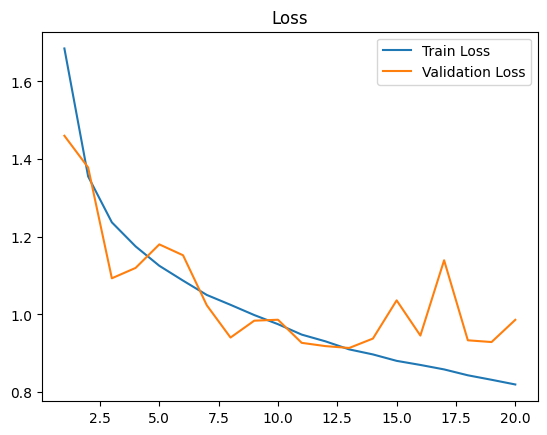

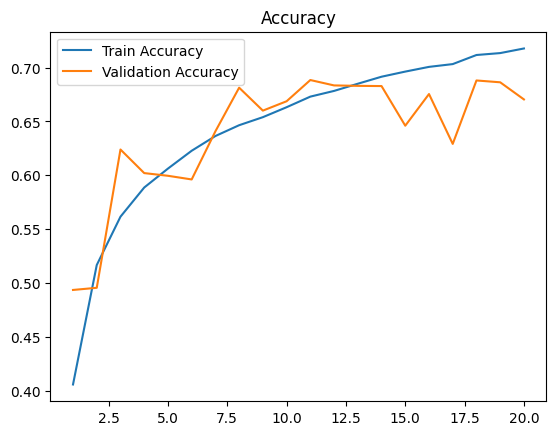

In [15]:
plt.figure()
plt.plot(np.arange(1,n_batch+1,1),history.history['loss'],label="Train Loss")
plt.plot(np.arange(1,n_batch+1,1),history.history['val_loss'],label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.figure()
plt.plot(np.arange(1,n_batch+1,1),history.history['accuracy'],label="Train Accuracy")
plt.plot(np.arange(1,n_batch+1,1),history.history['val_accuracy'],label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

score = cnn_model.evaluate(x_test, y_test_categorical, verbose=0)
print("Accuracy:")
print(score[1])
print("1.Wert: 0.6937999725341797")
print("mit l1 in 2. dense-layer: 0.6696000099182129")
print("mit l2 in 2. dense-layer: 0.7009000182151794")
print("mit Dropout nach input: 0.6467999815940857")
print("mit l2 in 1. dense-layer: 0.6060000061988831")
print("mit Dropout nach 1. dense layer, 0.1: 0.7028999924659729")
print("mit Dropout nach 1. dense layer, 0.2: 0.6952999830245972")
print("mit Dropout nach 1. dense layer, 0.2: 0.695900022983551")
print("mit Batchnormalization: 0.7085000276565552")
print("mit Batchnomalizatin: 0.711899995803833")

<div class="alert alert-block alert-success">
<b>Frage 5.3.10:</b> Welches Netzwerk performt besser?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b> Das CNN ist besser.</div>


<div class="alert alert-block alert-success">
<b>Frage 5.3.11:</b> Wie viele Parameter haben die Netze? Verwenden Sie dazu die summary Methode (siehe Keras-Docs)...
</div>

In [16]:
print(nn_model.summary())
print(cnn_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_MLP (InputLayer)          │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flattening_MLP (Flatten)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden1_NN (Dense)              │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden2_NN (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_NN (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,565,152 (9.79 MB)

 Trainable params: 855,050 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,710,102 (6.52 MB)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_CNN (InputLayer)          │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatt_CNN (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC-1 (Dense)                    │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_CNN (Dense)              │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,596,992 (6.09 MB)

 Trainable params: 532,298 (2.03 MB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 1,064,598 (4.06 MB)

None


<div class="alert alert-block alert-success">
<b>Frage 5.3.12:</b> Wo sind die meisten Parameter in diesem CNN gespeichert?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b> In der Dense-Schicht</div>


#### Challenge: Optimieren Sie Ihr Network! 

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.13:</b> Versuchen Sie, eines der Modelle so zu verbessern, dass Ihre Validierungsgenauigkeit einmal höher als 0,75 Prozent ist!

<ul>
<li>Hinweis: Versuchen Sie, zuerst zu overfitten und dann zu regulieren. 
<li>Hinweis 2: Verwenden Sie daher L1/L2 - Regularisierung und/oder Dropout. Auch BatchNormalization könnte die Sache verbessern. Schauen Sie deshalb auf der Keras-Website nach Beispielen oder fragen Sie Tutoren.
<li>Hinweis 3: Verwenden Sie eine der Funktionen <code>def model_nn()</code> oder <code>def model_cnn()</code> von oben. Viel Spaß und gutes Gelingen!

</li>
</ul>
</div>

### Daten Augmentation

Eine weitere Möglichkeit, Ihr Netzwerk zu regularisieren, ist das Vergrößern der Trainingsdaten. Verwenden Sie dazu den ImageDataGenerator von Keras. Wir werden später selbst Bilder verschieben und drehen, nachdem wir auf Cifar-10 optimiert haben.

In [17]:
# Keras ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

#### Eine etwas noch herausfordernde Challenge ((COOKIE AUFGABE! :)))

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.14:</b> Verbessern Sie Ihr Modell und passen Sie es an, wie genau kann es jetzt werden?
Die Lösung ist in der Lage, eine Genauigkeit von 0,8894 bei der Validierung zu erreichen.
</div>

In [72]:
def model_cnn_aug()->Model:

    input_layer = Input(shape = x_train.shape[1:], name='Input_CNN') # channels last
    
    conv1 = Conv2D(filters= 16, kernel_size = (3,3), padding='same', name='Conv1')(input_layer)
    batch1=BatchNormalization()(conv1)
    act1=Activation("relu")(batch1)
    max_pool1 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding='valid', name='Pool1')(act1)
    drop1=Dropout(0.2)(max_pool1)

    conv2 = Conv2D(filters = 32, kernel_size = (3,3), padding='same', name='Conv2')(drop1)
    batch2=BatchNormalization()(conv2)
    act2=Activation("relu")(batch2)
    max_pool2 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding='valid', name='Pool2')(act2)
    drop2=Dropout(0.2)(max_pool2)

    flattened = Flatten(name='Flatt_CNN')(drop2)
    
    fc1 = Dense(256, activation = 'relu', name='FC-1')(flattened)
    drop3=Dropout(0.2)(fc1)
    output = Dense(num_classes, activation = 'softmax', name='Output_CNN')(drop3)
    
    model = Model(inputs= input_layer, outputs = output)
    
    
    return model

In [73]:
# Train your model that makes use of data augmentation
# Fit the training data to the data-generator
datagen.fit(x_train)

# Train your CNN_augmentation model:
cnn_aug_model = model_cnn_aug()
cnn_aug_model.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer='Adam')
# config_cnn_aug = 'None' # give a recognizable name
# cnn_logger = TensorBoard(log_dir='logs/cnn_aug_logs/'+config_cnn_aug+'/') 
n_epoch=15
history=cnn_aug_model.fit(datagen.flow(x_train, y_train_categorical, batch_size = 5),
                            epochs=n_epoch, validation_data=(x_test, y_test_categorical),
                            verbose=1, steps_per_epoch=10000)


Epoch 1/15


c:\Users\anderlfr\gitlab_projects\AMALEA\AMALEA_3_13\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.3064 - loss: 1.8627 - val_accuracy: 0.4335 - val_loss: 1.6271
Epoch 2/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.3839 - loss: 1.6687 - val_accuracy: 0.4308 - val_loss: 1.5075
Epoch 3/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.4210 - loss: 1.5843 - val_accuracy: 0.5017 - val_loss: 1.4449
Epoch 4/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.4457 - loss: 1.5288 - val_accuracy: 0.4944 - val_loss: 1.3935
Epoch 5/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.4650 - loss: 1.4857 - val_accuracy: 0.5778 - val_loss: 1.1870
Epoch 6/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.4758 - loss: 1.4496 - val_accuracy: 0.5415 - val_loss: 1.2785
Epoch 7/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.4849 - loss: 1.4296 - val_accuracy: 0.5770 - val_loss: 1.1882
Epoch 8/15
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.4964 - lo

Accuracy:
0.6568999886512756
letzter Wert: 0.6165000200271606
letzter Wert: 0.6446999907493591


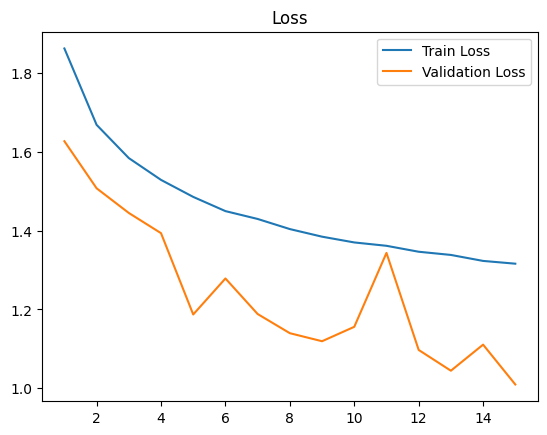

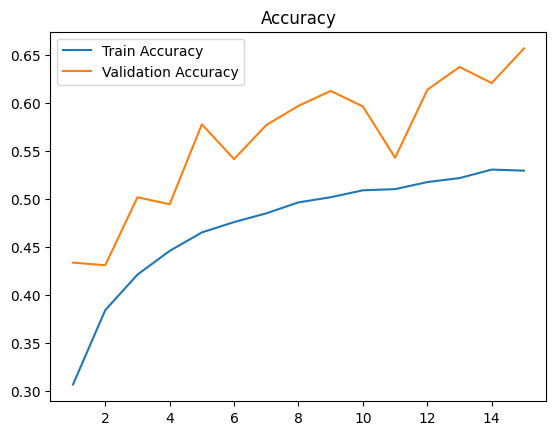

In [74]:
plt.figure()
plt.plot(np.arange(1,n_epoch+1,1),history.history['loss'],label="Train Loss")
plt.plot(np.arange(1,n_epoch+1,1),history.history['val_loss'],label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.figure()
plt.plot(np.arange(1,n_epoch+1,1),history.history['accuracy'],label="Train Accuracy")
plt.plot(np.arange(1,n_epoch+1,1),history.history['val_accuracy'],label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

score = cnn_aug_model.evaluate(x_test, y_test_categorical, verbose=0)
print("Accuracy:")
print(score[1])
print("letzter Wert: 0.6165000200271606")
print("letzter Wert: 0.6446999907493591")



<div class="alert alert-block alert-success">
<b>Frage 5.3.15:</b> Können Sie sich vorstellen, warum die Labels in der Codezelle oben nicht erweitert wurden und ob das notwendig sein könnte? Wenn Ihnen die Intuition fehlt, können Sie auf diese Frage zurückkommen, nachdem Sie das Notebook oder die Implementierung der Datenerweiterung unten abgeschlossen haben. 
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b> Weil die Klassenlabel nicht verändert wurden.</div>


<div class="alert alert-block alert-success">
<b>Frage 5.3.16:</b> Was denken Sie, was mit den vom DataGenerator angepassten Bildern passiert?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b> Die Bilder werden gedreht, gespiegelt und verschoben.</div>


### Sagen Sie mit Ihrem Model vorher

In [44]:
# Get the probabilities of one image prediction
number_sample = 18 
x_tester = x_test[number_sample,:,:,:]  

# Use numpy expand_dims before predicting with your model
# Print your predicted classes for the first test image (x_test[0,:,:,:])

# STUDENT CODE HERE
classes=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
pred=cnn_aug_model.predict(np.expand_dims(x_tester,axis=0))
print(np.round(pred,3))
ind=np.argmax(np.round(pred,3))
print(classes[ind])


# STUDENT CODE until HERE


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.045 0.006 0.    0.001 0.    0.    0.    0.    0.924 0.023]]
ship


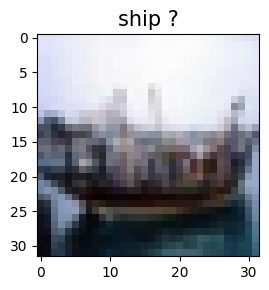

In [ ]:
fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.set_title(classes[y_test[number_sample].item()]+' ?', fontsize = 15)
ax.imshow(x_test[number_sample,:,:,:], interpolation='nearest')
plt.tight_layout()

<div class="alert alert-block alert-success">
<b>Frage 5.3.17:</b> Mit wie viel Konfidenz wurde Bild <b>18</b> in der Testmenge von Ihrem Modell als Vogel vorhergesagt?
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b>0.924</div>


### Schauen wir genauer hin / Ermitteln Sie die Gewichte in einer Faltungsschicht (engl. convolutional layer)

In [62]:
# Get the weights of a layer of one of your models, you specified by name
layer_visual = cnn_model.get_layer('Conv2') 
weights = layer_visual.get_weights()[0]

# Take some of them, last dimension are the channels
print(weights.shape)
weights_2d = weights[0,0,:,:] # filters are [:,:, dimension of spatial input (e.g.: rgb=3), nb_filters] in a layer
weights_2d

(3, 3, 16, 32)


array([[ 2.00786948e-01, -7.40760043e-02,  3.18027176e-02,
        -3.31845254e-01,  2.15071198e-02,  1.99190944e-01,
         2.98217218e-02, -2.87899554e-01,  2.05903072e-02,
        -7.85854831e-03, -6.19323328e-02,  9.97726694e-02,
         1.74806997e-01, -1.20086223e-01,  1.17732882e-01,
         5.86206019e-02,  1.20279759e-01, -1.51828691e-01,
        -2.57183731e-01,  1.13656096e-01,  9.71390121e-03,
         1.14523053e-01, -2.43532024e-02, -2.36143731e-02,
        -3.79124889e-03, -1.01634882e-01,  5.32687118e-05,
        -1.32358596e-01, -6.95224525e-03,  7.07187131e-02,
        -1.83330700e-01,  1.40512735e-01],
       [ 1.21924430e-01, -1.35168545e-02, -6.70992136e-02,
        -4.90118638e-02,  1.59883738e-01, -2.84948759e-02,
        -1.02009792e-02, -7.91805387e-02,  1.95387229e-01,
        -4.98395152e-02, -1.15953043e-01, -9.41697210e-02,
        -9.27322358e-02, -1.68022752e-01, -6.42273873e-02,
        -9.38728545e-03,  1.27832726e-01,  8.07296932e-02,
         1.33

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.18:</b> Schauen Sie sich die Schicht Conv2 (oder eine andere Schicht als Conv1) an und zeichnen Sie eine Filter-Kernel-Scheibe ihres dritten Filters. Tipp: Verwenden Sie weights.shape, um die Dimensionen des Kernels zu verstehen.
</div>

<div class="alert alert-block alert-success">
<b>Frage 5.3.19:</b> Erklären Sie, was die Dimensionen a,b,c und d in 'weights[a,b,c,d]' sind, wie es im obigen Codeblock verwendet wird.
</div>

<div class="alert alert-block alert-success">
<b>Ihre Antwort:</b></div>










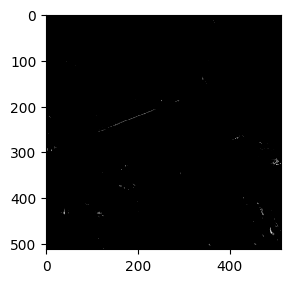

In [63]:
#Load Ascent image from scipy and convolve it with the previous loaded filter
import scipy.datasets
ascent = scipy.datasets.ascent()
ascent = signal.convolve2d(ascent, weights_2d, boundary='symm', mode='same')
ascent = np.maximum(ascent, 0)
fig, ax = plt.subplots(figsize=(figure_inches, figure_inches))
ax.imshow(ascent, interpolation='nearest', cmap='gray')
plt.tight_layout()

<div class="alert alert-block alert-success">
<b>Aufgabe 5.3.20:</b> Verwenden Sie verschiedene Filter auf das Inputbild. Können Sie irgendwelche Unterschiede feststellen? 
</div>

<div class="alert alert-block alert-success">
<b>Antwort:</b> Die Filter extrahieren nur gant bestimmte Teile (Linien des Bildes). Der Rest ist schwarz
</div>

### Visualisierung von Aktivierung in einem Feedforward-Durchlauf 

Im folgenden Code werden wir direkt die Ausgabe der Faltungsschicht im CNN verwenden und visualisieren. Dies entspricht in etwa dem, was wir oben gemacht haben.  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


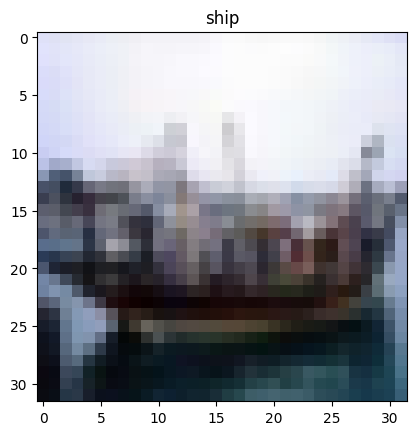

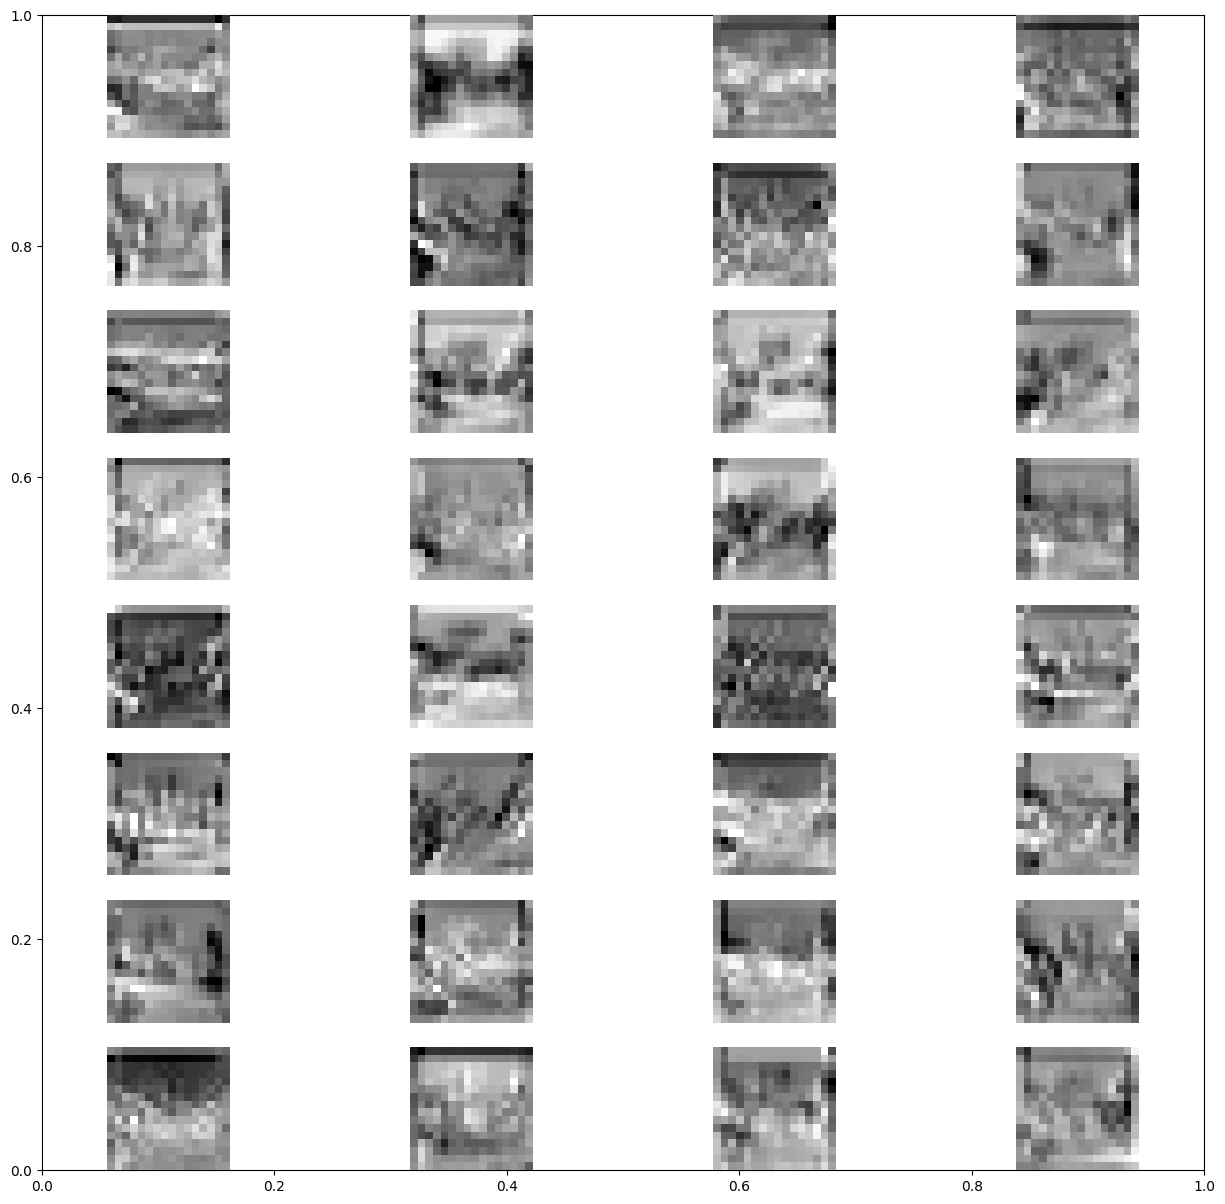

In [69]:
# Get the output in a feedforward process from a model with get_output function
number_sample = 18

# Model and layer where the feature maps come from

input_sample = np.expand_dims(x_test[number_sample, :, :, :], axis=0)
intermediate_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer(name='Conv2').output)
feature_map = intermediate_model.predict(input_sample)

# Take only 32 filters of the layer if there are so many
feature_map = feature_map[:,:,:,:32]

plt.imshow(x_test[number_sample,:,:,:])
plt.title(classes[y_test[number_sample].item()])
plt.subplots(figsize=(15, 15))

num_columns = 4
num_rows = 8
for i in range(0,feature_map.shape[-1]):
    
    plt.subplot(num_rows, num_columns, i+1)
    plt.imshow(feature_map[0,:,:,i], cmap ='gray')
    plt.axis('off')